
Ethereum Historical dataset
```
(https://finance.yahoo.com/quote/ETH-USD/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAHhBLSY1-QzWHStroNBQEIpa7cMFcsdlrSjp_zRbkbQlzrXw6cmAJHJz7JolkH-1dBgNV692giH_MWKeNMyRC7XKk98hHUa9v5RZ9H81ldNzTEYIWfl6peqUO-7583tpbW4jlXEV2VYVOBX2DfTundpK1beChrX_aqLrTHQ6tNOu)
```


Sentiment Analysis dataset
```
(https://en.wikipedia.org/wiki/Ethereum)
```



In [2]:
# Installing  Libraries
!pip install mwclient
!pip install torch torchvision torchaudio
!pip install statistics

In [3]:
# Importing Libraries
import mwclient
import time
import pandas as pd
import torch
from transformers import pipeline
from statistics import mean
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
import yfinance as yf
import os
import pandas as pd
site = mwclient.Site("en.Wikipedia.org")
page = site.pages["Ethereum"]

In [4]:
# Get a list of revisions
revs = list(page.revisions())

In [5]:
revs[0]

OrderedDict([('revid', 1311515079),
             ('parentid', 1311514717),
             ('user', 'SolVesc'),
             ('timestamp',
              time.struct_time(tm_year=2025, tm_mon=9, tm_mday=15, tm_hour=14, tm_min=30, tm_sec=50, tm_wday=0, tm_yday=258, tm_isdst=-1)),
             ('comment', '')])

In [6]:
revs = sorted(revs, key=lambda rev: rev["timestamp"])

In [7]:
revs[0]

OrderedDict([('revid', 592567939),
             ('parentid', 0),
             ('user', 'Sanpitch'),
             ('timestamp',
              time.struct_time(tm_year=2014, tm_mon=1, tm_mday=27, tm_hour=1, tm_min=53, tm_sec=45, tm_wday=0, tm_yday=27, tm_isdst=-1)),
             ('comment',
              "[[WP:AES|←]]Created page with '{{Infobox currency | image_1 =  | image_title_1 =  | image_width_1 =  | image_2 =  | image_title_2 =  | image_width_2 =  |issuing_authority = None. The Ethereum...'")])

In [8]:
# Analyzing the sentiment
sentiment_pipeline = pipeline("sentiment-analysis")

def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1
    return score

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Device set to use cpu


In [9]:
edits = {}

#converting date into string format from a named tuple
for rev in revs:
  date = time.strftime("%Y-%m-%d", rev["timestamp"])

  if date not in edits:
    edits[date] = dict(sentiments=list(), edit_count=0)

  edits[date]["edit_count"] += 1
  comment = rev.get("comment", "")
  edits[date]["sentiments"].append(find_sentiment(comment))

In [10]:
from statistics import mean
# Calculating Sentiment score and Negative Sentiment score
for key in edits:
  if len(edits[key]["sentiments"]) > 0:
    edits[key]["sentiment"] = mean(edits[key]["sentiments"])
    edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"])
  else:
    edits[key]["sentiment"] = 0
    edits[key]["neg_sentiment"] = 0

  del edits[key]["sentiments"]

In [11]:
edits

{'2014-01-27': {'edit_count': 1,
  'sentiment': -0.9985105395317078,
  'neg_sentiment': 1.0},
 '2014-02-01': {'edit_count': 1,
  'sentiment': -0.997276246547699,
  'neg_sentiment': 1.0},
 '2014-04-06': {'edit_count': 5,
  'sentiment': 0.7909794330596924,
  'neg_sentiment': 0.0},
 '2014-04-09': {'edit_count': 24,
  'sentiment': 0.646406963467598,
  'neg_sentiment': 0.08333333333333333},
 '2014-04-10': {'edit_count': 9,
  'sentiment': -0.36151769426133895,
  'neg_sentiment': 0.6666666666666666},
 '2014-04-11': {'edit_count': 10,
  'sentiment': 0.5150127589702607,
  'neg_sentiment': 0.2},
 '2014-04-12': {'edit_count': 2,
  'sentiment': -0.04391053318977356,
  'neg_sentiment': 0.5},
 '2014-04-13': {'edit_count': 1,
  'sentiment': 0.748120903968811,
  'neg_sentiment': 0.0},
 '2014-04-17': {'edit_count': 9,
  'sentiment': 0.30852225091722274,
  'neg_sentiment': 0.3333333333333333},
 '2014-04-18': {'edit_count': 1,
  'sentiment': 0.9109594821929932,
  'neg_sentiment': 0.0},
 '2014-04-24': {'e

In [12]:
# Converting to Pandas dataframe from dictionary
edits_df = pd.DataFrame.from_dict(edits, orient="index")

In [13]:
edits_df

,edit_count,sentiment,neg_sentiment
2014-01-27,1,-0.998511,1.000000
2014-02-01,1,-0.997276,1.000000
2014-04-06,5,0.790979,0.000000
2014-04-09,24,0.646407,0.083333
2014-04-10,9,-0.361518,0.666667
...,...,...,...
2025-08-25,1,-0.999620,1.000000
2025-08-29,3,0.253291,0.333333
2025-09-03,2,-0.022424,0.500000
2025-09-08,2,0.744423,0.000000


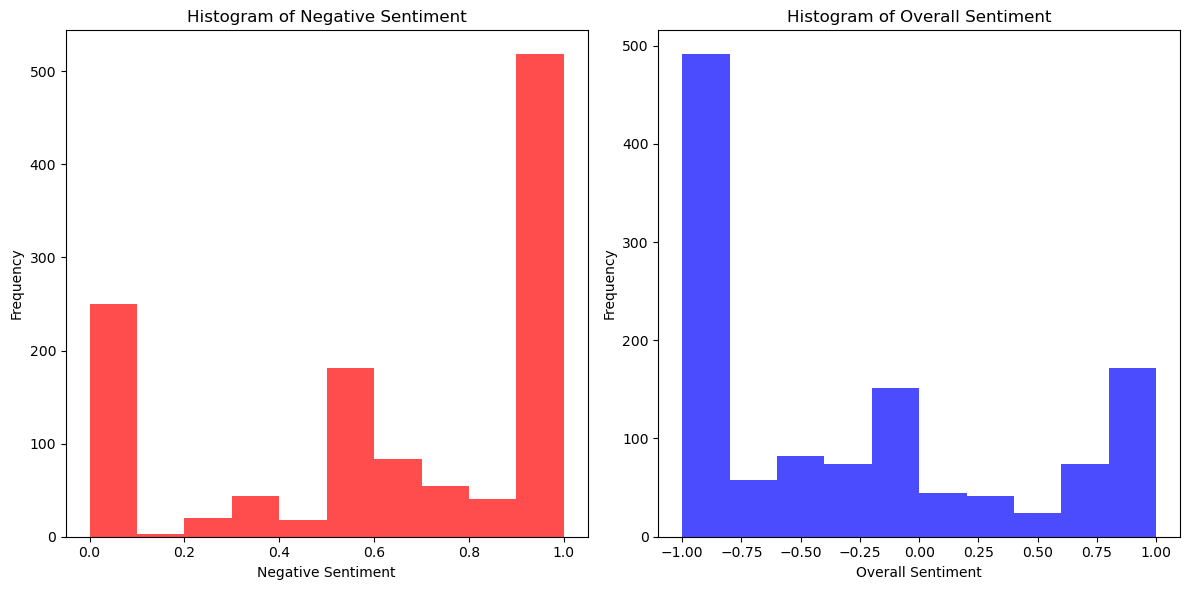

In [14]:
import matplotlib.pyplot as plt

# Extracting neg_sentiment and sentiment values
neg_sentiment_values = [edits[key]["neg_sentiment"] for key in edits]
sentiment_values = [edits[key]["sentiment"] for key in edits]

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for neg_sentiment
plt.subplot(1, 2, 1)
plt.hist(neg_sentiment_values, bins=10, color='red', alpha=0.7)
plt.title('Histogram of Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Frequency')

# Histogram for sentiment
plt.subplot(1, 2, 2)
plt.hist(sentiment_values, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Overall Sentiment')
plt.xlabel('Overall Sentiment')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [15]:
edits_df.index = pd.to_datetime(edits_df.index) # turning it from string to datetime obj

In [16]:
# Generating a date range from 2014-01-27
dates = pd.date_range(start="2014-01-27", end=datetime.today())

In [17]:
dates

DatetimeIndex(['2014-01-27', '2014-01-28', '2014-01-29', '2014-01-30',
               '2014-01-31', '2014-02-01', '2014-02-02', '2014-02-03',
               '2014-02-04', '2014-02-05',
               ...
               '2025-09-06', '2025-09-07', '2025-09-08', '2025-09-09',
               '2025-09-10', '2025-09-11', '2025-09-12', '2025-09-13',
               '2025-09-14', '2025-09-15'],
              dtype='datetime64[ns]', length=4250, freq='D')

In [18]:
edits_df = edits_df.reindex(dates, fill_value = 0)

In [19]:
edits_df

,edit_count,sentiment,neg_sentiment
2014-01-27,1,-0.998511,1.0
2014-01-28,0,0.000000,0.0
2014-01-29,0,0.000000,0.0
2014-01-30,0,0.000000,0.0
2014-01-31,0,0.000000,0.0
...,...,...,...
2025-09-11,0,0.000000,0.0
2025-09-12,0,0.000000,0.0
2025-09-13,0,0.000000,0.0
2025-09-14,0,0.000000,0.0


In [20]:
#Creata a rollong avg for the sentiment
rolling_edits = edits_df.rolling(30).mean()

In [21]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-01-27,NaN,NaN,NaN
2014-01-28,NaN,NaN,NaN
2014-01-29,NaN,NaN,NaN
2014-01-30,NaN,NaN,NaN
2014-01-31,NaN,NaN,NaN
...,...,...,...
2025-09-11,0.266667,-0.000811,0.061111
2025-09-12,0.266667,-0.000811,0.061111
2025-09-13,0.266667,-0.000811,0.061111
2025-09-14,0.266667,-0.000811,0.061111


In [22]:
# Dropping rows with missing values
rolling_edits = rolling_edits.dropna()

In [23]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2014-02-25,0.066667,-0.066526,0.066667
2014-02-26,0.033333,-0.033243,0.033333
2014-02-27,0.033333,-0.033243,0.033333
2014-02-28,0.033333,-0.033243,0.033333
2014-03-01,0.033333,-0.033243,0.033333
...,...,...,...
2025-09-11,0.266667,-0.000811,0.061111
2025-09-12,0.266667,-0.000811,0.061111
2025-09-13,0.266667,-0.000811,0.061111
2025-09-14,0.266667,-0.000811,0.061111


In [24]:
# Saving the dataframe to a CSV file
rolling_edits.to_csv("Wikipedia_Edits.csv ")

In [25]:
# Getting the price history of ethereum
eth_ticker = yf.Ticker("ETH-USD")

In [26]:
# Fetching historical price data for Ethereum
eth = eth_ticker.history(period = "max")

In [27]:
eth

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-11 00:00:00+00:00,4349.200195,4471.698730,4339.716797,4461.233398,35959212991,0.0,0.0
2025-09-12 00:00:00+00:00,4461.479492,4734.273926,4453.284668,4715.246094,43839753626,0.0,0.0
2025-09-13 00:00:00+00:00,4714.703613,4763.361328,4609.125488,4668.179688,34843845977,0.0,0.0


In [28]:
# Convert index to datetime and remove timezone information
eth.index = pd.to_datetime(eth.index)
eth.index = eth.index.tz_localize(None)

In [29]:
# Deleting columns
del eth["Dividends"]
del eth["Stock Splits"]

<Axes: title={'center': 'Visualization of Ethereum price trends'}, xlabel='Date'>

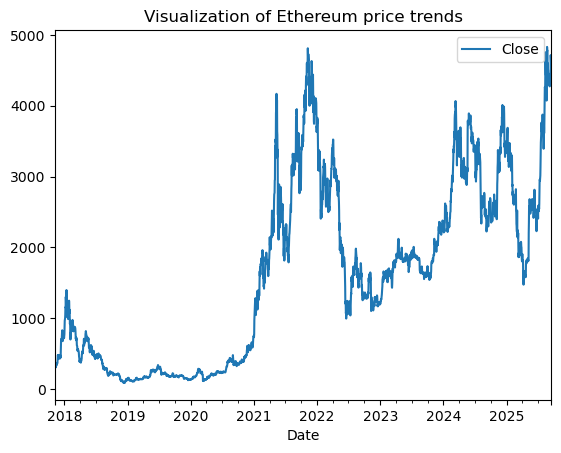

In [30]:
# Plotting Ethereum closing price trends over time
eth.plot.line(y="Close", use_index=True, title="Visualization of Ethereum price trends")

In [31]:
# Reading the Wikipedia edits data from a CSV file into a DataFrame
wiki = pd.read_csv("/content/Wikipedia_Edits.csv ", index_col=0, parse_dates=True)

C:\Users\sanja\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\sanja\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\sanja\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\Users\sanja\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\sanja\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Wikipedia_Edits.csv '

In [ ]:
wiki

In [ ]:
# Merging the Ethereum price data with the Wikipedia edits data based on their index (date)
eth = eth.merge(wiki, left_index=True, right_index=True)

In [ ]:
eth

In [ ]:
eth["Tomorrow"] = eth["Close"].shift(-1)

In [ ]:
eth["Target"] = (eth["Tomorrow"] > eth["Close"]).astype(int)

In [ ]:
eth["Target"].value_counts()

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
train = eth.iloc[:-200]
test = eth[-200:]
predictors = ["Close", "Volume", "Open", "High", "Low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["Target"])

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds) # Baseline precicsion score

In [ ]:
#  Function to make predictions using a trained model.
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index)
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [ ]:
# Function to perform backtesting on a given dataset using a trained model.
def  backtest(data, model, predictors, start=1095, step=150):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train,test, predictors, model)
    all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
Predictions = backtest(eth, model, predictors)

In [ ]:
Predictions.rename(columns={0: 'predictions'}, inplace=True)

In [ ]:
precision_score(Predictions["Target"], Predictions["predictions"])

In [ ]:
predictions